In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Code d'extraction des utilisateurs et de leurs contributions

In [ ]:
#!pip install wikipedia-api pandas requests
import wikipediaapi  # API pour accéder à Wikipedia
import pandas as pd
import requests
import time
import re
import urllib.parse

# Initialisation de l'API Wikipedia
user_agent = "GenderAnalysisProject/1.0 (sow@.com)"
wiki = wikipediaapi.Wikipedia(language='en', user_agent=user_agent)

# Liste des langues à explorer
languages = [
    'en', 'de', 'fr', 'es', 'it', 'ru', 'ja', 'zh', 'pt', 'pl', 'ar', 'nl', 'sv', 'uk', 'vi',
    'ca', 'no', 'fi', 'cs', 'hu', 'ko', 'el', 'he', 'ro', 'da', 'id', 'fa', 'tr', 'eo', 'bg',
    'sk', 'sl', 'lt', 'sr', 'hr', 'ms', 'th', 'kk', 'hi', 'et', 'az', 'simple', 'gl', 'eu',
    'bs', 'bn', 'la', 'vo', 'is', 'cy', 'mk', 'lb', 'sq', 'ta', 'sh', 'oc', 'ka', 'be',
    'ur', 'af', 'ml', 'te', 'be-x-old', 'new', 'nn', 'hy', 'lv', 'pms', 'tt', 'tl', 'ht',
    'km', 'tg', 'mg', 'ky', 'sw', 'ast', 'uz', 'bn', 'zh-min-nan', 'zh-yue', 'ku',
    'ga', 'sco', 'mr', 'pa', 'su', 'nds', 'br', 'ia', 'ba', 'an', 'cv', 'io', 'nap',
    'bat-smg', 'gu', 'fy', 'als', 'lmo', 'ne', 'scn', 'war', 'yi', 'jv', 'map-bms',
    'bar', 'ckb', 'arz', 'hif', 'bpy', 'diq', 'mn', 'mnw', 'my', 'si', 'or',
    'gd', 'qu', 'sah', 'bug', 'nap', 'mhr', 'cdo', 'hak', 'am', 'kn', 'hsb', 'sa',
    'yo', 'mzn', 'vec', 'nah', 'se', 'gan', 'li', 'ilo', 'bcl', 'os', 'frr',
    'co', 'mrj', 'fo', 'vls', 'nds-nl', 'bo', 'xmf', 'lrc', 'ps', 'sd',
    'ban', 'pnb', 'nov', 'sc', 'tk', 'csb', 'gv', 'vep',
    'kv', 'zea', 'fiu-vro', 'pfl', 'ug', 'frp', 'kw', 'lad', 'kab', 'mi', 'mai',
    'wo', 'szl', 'gag', 'stq', 'so', 'ay', 'rm', 'lez', 'koi', 'myv', 'fur',
    'mt', 'gn', 'rue', 'as', 'om', 'ig', 'dv', 'dsb',
    'ext', 'haw', 'sn', 'ln', 'sm', 'pdc', 'ace', 'nv', 'to',
    'ab', 'xh', 'ki', 'za', 'ss', 've', 'ts', 'rw', 'cr', 'pih', 'tw', 'ff', 'bi',
    'ti', 'dz', 'ha', 'mus', 'ho', 'kg', 'kj', 'lg', 'mh', 'sg', 'ii', 'kr', 'hz',
    'aa', 'cho', 'ch', 'ng'
]

# Fonction pour explorer une catégorie et ses sous-catégories pour obtenir les pages d'utilisateurs
def get_wikipedians_by_category(category_name):
    """
    Récupère une liste de contributeurs Wikipedia à partir d'une catégorie donnée, en parcourant les sous-catégories.
    :param category_name: Nom de la catégorie (par exemple, 'Female Wikipedians')
    :return: Liste des contributeurs
    """
    category = wiki.page(f"Category:{category_name}")
    wikipedians = []

    if category.exists():
        def process_category(cat):
            for member in cat.categorymembers.values():
                # Si la page est un utilisateur, on l'ajoute
                if member.ns == wikipediaapi.Namespace.USER:
                    username = member.title
                    # Supprimer le préfixe "User:" s'il est présent
                    if username.startswith('User:'):
                        username = username[len('User:'):]
                    username = username.strip()  # Supprimer les espaces superflus
                    wikipedians.append(username)
                # Si c'est une sous-catégorie, on la traite récursivement
                elif member.ns == wikipediaapi.Namespace.CATEGORY:
                    process_category(member)

        process_category(category)
    else:
        print(f"La catégorie {category_name} n'existe pas.")

    return wikipedians

# Collecter les contributeurs des trois catégories
female_wikipedians = get_wikipedians_by_category("Female_Wikipedians")
male_wikipedians = get_wikipedians_by_category("Male_Wikipedians")
transgender_wikipedians = get_wikipedians_by_category("Transgender_Wikipedians")

# Fonction pour extraire la localisation depuis le contenu de la page utilisateur
def extract_location_from_content(content):
    patterns = [
        r'\{\{\s*[Uu]ser location\s*\|\s*([^}|]+)',                    # {{User location|Location}}
        r'\{\{\s*[Uu]tilisateur\s*[Ll]ocalité\s*\|\s*([^}|]+)',        # {{Utilisateur Localité|Location}}
        r'This user lives in\s*[:]*\s*(.*?)\.',                        # "This user lives in: Location."
        r'This user lives in the\s*[:]*\s*(.*?)\.',                    # "This user lives in the: Location."
        r'This user is from\s*[:]*\s*(.*?)\.',                         # "This user is from: Location."
        r'This user resides in\s*[:]*\s*(.*?)\.',                      # "This user resides in: Location."
        r'This user comes from\s*[:]*\s*(.*?)\.',                      # "This user comes from: Location."
        r'This user is located in\s*[:]*\s*(.*?)\.',                   # "This user is located in: Location."
        r'This user was born in\s*[:]*\s*(.*?)\.',                     # "This user was born in: Location."
        r'This user is living in\s*[:]*\s*(.*?)\.',                    # "This user is living in: Location."
        r'I (?:live|am from|come from|reside in|was born in|am located in)\s*[:]*\s*(.*?)\s*(?:\.|,|\n|$)',  # "I live in: Location"
        r'My location is\s*[:]*\s*(.*?)\s*(?:\.|,|\n|$)',              # "My location is: Location"
        r'Resides in\s*[:]*\s*(.*?)\s*(?:\.|,|\n|$)',                  # "Resides in: Location"
        r'From\s*[:]*\s*(.*?)\s*(?:\.|,|\n|$)',                        # "From: Location"
        r'Based in\s*[:]*\s*(.*?)\s*(?:\.|,|\n|$)',                    # "Based in: Location"
        r'Living in\s*[:]*\s*(.*?)\s*(?:\.|,|\n|$)',                   # "Living in: Location"
        r'Born in\s*[:]*\s*(.*?)\s*(?:\.|,|\n|$)',                     # "Born in: Location"
        r'Home\s*[:=]\s*(.*?)\s*(?:\.|,|\n|$)',                        # "Home: Location" ou "Home = Location"
        r'Location\s*[:=]\s*(.*?)\s*(?:\.|,|\n|$)',                    # "Location: Location" ou "Location = Location"
        r'Country\s*[:=]\s*(.*?)\s*(?:\.|,|\n|$)',                     # "Country: Location" ou "Country = Location"
        r'City\s*[:=]\s*(.*?)\s*(?:\.|,|\n|$)',                        # "City: Location" ou "City = Location"
        r'\{\{\s*[Uu]ser\s*[Gg]eolocation\s*\|\s*(.*?)\s*\}\}',        # {{User Geolocation|Location}}
        r'\{\{\s*[Uu]serbox\s*\|\s*location\s*=\s*(.*?)\s*\}\}',       # {{Userbox|location=Location}}
        r'\{\{\s*[Uu]ser\s*[Ll]ocation\s*\|\s*(.*?)\s*\}\}',           # {{User Location|Location}}
        r'\{\{\s*[Uu]ser\s*[Ff]rom\s*\|\s*(.*?)\s*\}\}',               # {{User From|Location}}
        r'\|\s*country\s*=\s*(.*?)\s*(?:\||\n)',                       # "| country = Location"
        r'\|\s*location\s*=\s*(.*?)\s*(?:\||\n)',                      # "| location = Location"
        r'\|\s*residence\s*=\s*(.*?)\s*(?:\||\n)',                     # "| residence = Location"
        r'\|\s*hometown\s*=\s*(.*?)\s*(?:\||\n)',                      # "| hometown = Location"
        r'==\s*Location\s*==\s*(.*?)\s*(?:==|\n\n)',                   # "== Location == Location information"
        r'\{\{\s*[Bb]abel\s*\|\s*(.*?)\}\}',                           # {{Babel|...|Location}}
        r'\{\{\s*[Uu]ser\s*[Mm]aps\s*\|\s*(.*?)\s*\}\}',               # {{User Maps|Location}}
    ]

    for pattern in patterns:
        match = re.search(pattern, content, re.IGNORECASE)
        if match:
            location = match.group(1).strip()
            # Nettoyage de la localisation pour enlever les balises ou les caractères spéciaux
            location = re.sub(r'<.*?>', '', location)
            location = re.sub(r'\[\[|\]\]', '', location)
            location = location.split('|')[0].strip()
            return location
    return "Unknown"

# Fonction pour obtenir la localisation de l'utilisateur
def get_user_location(username, lang='en'):
    username_encoded = urllib.parse.quote(username)
    url_user = f"https://{lang}.wikipedia.org/w/api.php"
    params_user = {
        "action": "query",
        "titles": f"User:{username_encoded}",
        "prop": "revisions",
        "rvprop": "content",
        "format": "json",
        "formatversion": "2"
    }

    try:
        response_user = requests.get(url_user, params=params_user)
        if response_user.status_code == 200:
            data_user = response_user.json()  # Correction ici
            pages = data_user.get('query', {}).get('pages', [])
            for page in pages:
                if 'revisions' in page:
                    content = page['revisions'][0].get('content', '')
                    location = extract_location_from_content(content)
                    if location != "Unknown":
                        return location
    except Exception as e:
        print(f"Erreur lors de la récupération de la localisation pour {username} en {lang}: {e}")
    return "Unknown"

# Fonction pour obtenir les contributions d'un utilisateur
def get_user_contributions(username, limit=50):
    contributions = []
    username_encoded = urllib.parse.quote(username)
    for lang in languages:
        url_contrib = f"https://{lang}.wikipedia.org/w/api.php"
        params_contrib = {
            "action": "query",
            "list": "usercontribs",
            "ucuser": username_encoded,
            "uclimit": 500,
            "format": "json"
        }

        try:
            response_contrib = requests.get(url_contrib, params=params_contrib)
            if response_contrib.status_code == 200:
                data_contrib = response_contrib.json()
                if 'query' in data_contrib and 'usercontribs' in data_contrib['query']:
                    articles = {}
                    for contrib in data_contrib['query']['usercontribs']:
                        title = contrib['title']
                        if title not in articles:
                            articles[title] = []
                        articles[title].append(contrib)

                    # Prendre les 10 premières modifications par article
                    for title, contribs in articles.items():
                        for contrib in contribs[:10]:
                            contributions.append({
                                "title": contrib['title'],
                                "timestamp": contrib['timestamp'],
                                "language": lang
                            })
            time.sleep(0.3)  # Pause pour éviter de surcharger les serveurs
        except Exception as e:
            print(f"Erreur lors de la récupération des contributions pour {username} en {lang}: {e}")
    return contributions

# Fonction pour collecter les contributions et la localisation par genre
def collect_contributions_and_location(wikipedians, gender):
    for user in wikipedians:
        username = user.strip()
        # Ignorer les utilisateurs suspects
        if '/' in username or len(username) == 0:
            print(f"Ignorer l'utilisateur suspect: {username}")
            continue
        print(f"Traitement de l'utilisateur: {username} ({gender})")

        # Obtenir la localisation (par défaut en anglais)
        region = get_user_location(username, lang='en')
        print(f"Localisation trouvée: {region}")

        # Obtenir les contributions de l'utilisateur
        contributions = get_user_contributions(username)
        print(f"Nombre de contributions trouvées: {len(contributions)}")

        for contrib in contributions:
            all_contributions.append({
                "User": username,
                "Title": contrib['title'],
                "Timestamp": contrib['timestamp'],
                "Gender": gender,
                "Language": contrib.get('language', 'unknown'),
                "Region": region if region else 'unknown'
            })
        # Délai pour éviter de surcharger les serveurs de Wikipédia
        time.sleep(1)

# Liste pour stocker toutes les contributions avec la localisation
all_contributions = []

# Collecter les contributions et la localisation pour chaque genre
collect_contributions_and_location(female_wikipedians, 'Female')
collect_contributions_and_location(male_wikipedians, 'Male')
collect_contributions_and_location(transgender_wikipedians, 'Transgender')

# Créer un DataFrame avec toutes les contributions
df_contributions = pd.DataFrame(all_contributions)

# Sauvegarder les données dans un fichier CSV
df_contributions.to_csv("wikipedia_contributions.csv",index=False)

# Afficher les premières lignes du DataFrame
print(df_contributions.head())


## Nettoyage des données avec API Geoname et Geopy

In [ ]:
# Nettoyage des données
#!pip install pycountry
import pycountry
import pandas as pd
import re
import requests
from geopy.geocoders import Nominatim
import time

# Charger les données collectées précédemment
try:
    df_contributions = pd.read_csv("wikipedia_contributions_with_geography6.csv", delimiter=",", )
except pd.errors.ParserError as e:
    print(f"Erreur lors de la lecture du fichier CSV: {e}")

# Nettoyer les valeurs de la colonne Region pour supprimer les caractères indésirables
def clean_location(location):
    # Supprimer les caractères spéciaux
    location = re.sub(r'[^a-zA-Z0-9,\s]', '', location)
    # Supprimer les espaces superflus
    location = location.strip()
    return location

df_contributions['Region'] = df_contributions['Region'].apply(clean_location)

# Vérifier si une localisation est un pays ou une ville connue
def is_valid_location(location):
    # Vérifier si la localisation est un pays
    try:
        pycountry.countries.lookup(location)
        return True
    except LookupError:
        pass

    # Vérifier si la localisation est une ville via GeoNames
    geonames_username = "sow@com"
    url = f"http://api.geonames.org/searchJSON?q={location}&maxRows=1&username={geonames_username}"
    try:
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            data = response.json()
            if data['totalResultsCount'] > 0:
                return True
    except Exception as e:
        print(f"Erreur lors de la vérification de la localisation {location} avec GeoNames: {e}")

    # Si GeoNames échoue, vérifie avec geopy
    geolocator = Nominatim(user_agent="geoapiExercises", timeout=10)
    try:
        time.sleep(2)
        geo_data = geolocator.geocode(location)
        if geo_data:
            return True
    except Exception as e:
        print(f"Erreur lors de la vérification de la localisation {location} avec geopy: {e}")

    return False

# Filtrer les localisations invalides
df_contributions['Valid_Region'] = df_contributions['Region'].apply(is_valid_location)
df_contributions = df_contributions[df_contributions['Valid_Region']]
df_contributions = df_contributions.drop(columns=['Valid_Region'])


# Sauvegarder les données nettoyées dans un nouveau fichier CSV
df_contributions.to_csv("fichier.csv", index=False)

# Afficher les premières lignes du DataFrame nettoyé
print(df_contributions.head())


##Chargement des données

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
import warnings

# Charger les fichiers CSV
male_df = pd.read_csv('/content/drive/MyDrive/WIKI/Male.csv')
female_df = pd.read_csv('/content/drive/MyDrive/WIKI/Femal.csv')
transgender_df = pd.read_csv('/content/drive/MyDrive/WIKI/Transgenre.csv')

# Fusionner les données
data = pd.concat([male_df, female_df, transgender_df], ignore_index=True)
data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')
data['YearMonth'] = data['Timestamp'].dt.to_period('M')

# Nettoyer les données : ne garder que les genres valides
valid_genders = ['Male', 'Female', 'Transgender']
data = data[data['Gender'].isin(valid_genders)]

# Agrégations
contributions_by_gender = data['Gender'].value_counts()
time_aggregation = data.groupby(['YearMonth', 'Gender']).size().reset_index(name='Counts')
location_aggregation = data.groupby(['Region', 'Gender']).size().reset_index(name='Counts')



<ipython-input-2-365e5cb3321c>:16: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['YearMonth'] = data['Timestamp'].dt.to_period('M')


##Visualisations

In [3]:
import pandas as pd
import numpy as np
import plotly.express as px

language_aggregation = data.groupby(['Language', 'Gender']).size().reset_index(name='Counts')

# Palette de couleurs
colors = {'Male': 'blue', 'Female': 'orange', 'Transgender': 'green'}

# ================== Visualisation 1 : Contributions par genre (barres) ==================
fig1 = px.bar(
    contributions_by_gender.reset_index(),
    x=contributions_by_gender.index, y=contributions_by_gender.values,
    title="Nombre de contributions par genre",
    labels={"x": "Genre", "y": "Nombre de contributions"},
    color=contributions_by_gender.index,
    color_discrete_map=colors
)
fig1.show()

# ================== Visualisation 2 : Contributions par genre (circulaire) ==================
plt.figure()
fig2 = px.pie(
    contributions_by_gender.reset_index(),
    names=contributions_by_gender.index, values=contributions_by_gender.values,
    title="Répartition des contributions par genre",
    color=contributions_by_gender.index,
    color_discrete_map=colors,
    hole=0.4
)
fig2.show()

# ================== Visualisation 3 : Évolution des contributions par genre dans le temps ==================
time_aggregation['YearMonth'] = time_aggregation['YearMonth'].astype(str)

plt.figure()
fig3 = px.line(
    time_aggregation,
    x="YearMonth", y="Counts",
    color="Gender",
    title="Évolution des contributions par genre dans le temps",
    labels={"YearMonth": "Temps", "Counts": "Nombre de contributions"},
    color_discrete_map=colors
)
fig3.show()

# ================== Visualisation 4 : Contributions par localisation et genre ==================
top_locations = location_aggregation.groupby('Region')['Counts'].sum().nlargest(10).index
top_location_data = location_aggregation[location_aggregation['Region'].isin(top_locations)]
plt.figure()
fig4 = px.bar(
    top_location_data,
    x="Region", y="Counts",
    color="Gender",
    title="Top 10 contributions par localisation et par genre",
    labels={"Region": "Région", "Counts": "Nombre de contributions"},
    color_discrete_map=colors,
    barmode="group"
)
fig4.show()

# ================== Visualisation 5 : Contributions par langue ==================
top_languages = language_aggregation.groupby('Language')['Counts'].sum().nlargest(5).index
top_language_data = language_aggregation[language_aggregation['Language'].isin(top_languages)]
plt.figure()
fig5 = px.bar(
    top_language_data,
    x="Language", y="Counts",
    color="Gender",
    title="Top 5 contributions par langue et par genre",
    labels={"Language": "Langue", "Counts": "Nombre de contributions"},
    color_discrete_map=colors,
    barmode="group"
)
fig5.show()


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

#DBPEDIA

In [ ]:
# Extraire les titres uniques
unique_titles = data['Title'].drop_duplicates().tolist()
print(f"Nombre de titres uniques à traiter : {len(unique_titles)}")


Nombre de titres uniques à traiter : 308933


## Enrichissement des données pour avoir pour chaque titre un résumé

In [ ]:
import json
import pandas as pd
from tqdm import tqdm
import urllib.parse
import torch
from multiprocessing import Pool, cpu_count

# Vérifiez si un GPU est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation de l'appareil : {device}")

# Charger ou initialiser le cache local
try:
    with open("dbpedia_cache.json", "r") as file:
        dbpedia_cache = json.load(file)
except (FileNotFoundError, json.JSONDecodeError):
    dbpedia_cache = {}
    print("Fichier cache introuvable ou corrompu. Initialisation d'un nouveau cache.")

# Charger les fichiers CSV
male_df = pd.read_csv('/content/drive/MyDrive/WIKI/Male.csv')
female_df = pd.read_csv('/content/drive/MyDrive/WIKI/Femal.csv')
transgender_df = pd.read_csv('/content/drive/MyDrive/WIKI/Trangenre.csv')

# Fusionner les données
data = pd.concat([male_df, female_df, transgender_df], ignore_index=True)
data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')
data['YearMonth'] = data['Timestamp'].dt.to_period('M')  # Ajouter une colonne année-mois
data.drop_duplicates(subset=['Title'], inplace=True)
unique_titles = data['Title'].tolist()

# Fonction pour échapper les titres
def escape_title(title):
    return urllib.parse.quote(title)

# requête DBpedia
def query_dbpedia_batch(titles):
    results = []
    for title in titles:
        escaped_title = escape_title(title)
        results.append({
            'label': title,
            'category': f"Category for {title}",
            'abstract': f"Abstract for {title}"
        })
    return results

# Nettoyage des résultats DBpedia
def clean_results(results):
    cleaned = []
    for result in results:
        cleaned.append({
            'label': result.get('label', ''),
            'category': result.get('category', ''),
            'abstract': result.get('abstract', '')
        })
    return cleaned

# Fonction pour traiter un lot unique
def process_batch(batch):
    try:
        results = query_dbpedia_batch(batch)
        cleaned_results = clean_results(results)
        return cleaned_results
    except Exception as e:
        print(f"Erreur lors du traitement du batch : {e}")
        return []

# Taille des lots
batch_size = 100
batches = [
    unique_titles[i:i + batch_size]
    for i in range(0, len(unique_titles), batch_size)
    if not all(title in dbpedia_cache for title in unique_titles[i:i + batch_size])
]

# Traitement des lots en parallèle
num_processes = min(cpu_count(), 10)
with Pool(num_processes) as pool:
    for cleaned_results in tqdm(pool.imap(process_batch, batches), total=len(batches)):
        for result in cleaned_results:
            dbpedia_cache[result['label']] = {
                'category': result.get('category', ''),
                'abstract': result.get('abstract', '')
            }

# Sauvegarder le cache DBpedia
with open("dbpedia_cache.json", "w") as file:
    json.dump(dbpedia_cache, file)

# Enrichir le dataset initial
data['Category'] = data['Title'].map(lambda x: dbpedia_cache.get(x, {}).get('category', ''))
data['Abstract'] = data['Title'].map(lambda x: dbpedia_cache.get(x, {}).get('abstract', ''))

# Sauvegarder le dataset enrichi dans le dossier spécifié
enriched_filename = "/content/drive/MyDrive/WIKI/enriched_dataset.csv"
data.to_csv(enriched_filename, index=False)
print(f"Dataset enrichi sauvegardé dans le fichier : {enriched_filename}")


Utilisation de l'appareil : cpu


0it [00:00, ?it/s]


Dataset enrichi sauvegardé dans le fichier : /content/drive/MyDrive/WIKI/enriched_dataset.csv


##Rajout de la colonne count qui représente le nombre de contributions par utilisateur

In [ ]:
import pandas as pd

# Charger le dataset enrichi
file_path = '/content/drive/MyDrive/WIKI/enriched_dataset.csv'
data = pd.read_csv(file_path)

# Ajouter une colonne 'Counts' représentant le nombre de contributions par 'User'
data['Counts'] = data.groupby('User')['User'].transform('count')

# Sauvegarder le dataset avec la nouvelle colonne
output_path = '/content/drive/MyDrive/WIKI/enriched_dataset_with_counts.csv'
data.to_csv(output_path, index=False)
print(f"Dataset enrichi avec la colonne 'Counts' sauvegardé dans : {output_path}")


Dataset enrichi avec la colonne 'Counts' sauvegardé dans : /content/drive/MyDrive/WIKI/enriched_dataset_with_counts.csv


##Etraction des titres les plus populaires

##Cluster

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from tabulate import tabulate

# Charger les fichiers CSV
male_df = pd.read_csv('/content/drive/MyDrive/WIKI/Male.csv')
female_df = pd.read_csv('/content/drive/MyDrive/WIKI/Femal.csv')
transgender_df = pd.read_csv('/content/drive/MyDrive/WIKI/Trangenre.csv')

# Fusionner les données
data = pd.concat([male_df, female_df, transgender_df], ignore_index=True)
data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')

valid_genders = ['Male', 'Female', 'Transgender']
data = data[data['Gender'].isin(valid_genders)]

# Extraire les 150 titres les plus populaires par genre
top_titles_by_gender = data.groupby(['Gender', 'Title']).size().reset_index(name='Counts')
top_titles_by_gender = top_titles_by_gender.sort_values(['Gender', 'Counts'], ascending=[True, False])
top_titles = top_titles_by_gender.groupby('Gender').head(150)

titles = []
for gender in valid_genders:
    df_gender = top_titles[top_titles['Gender'] == gender]
    titles.extend(df_gender['Title'].tolist())

# Vectorisation TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(titles)

# Appliquer K-Means avec 30 clusters
num_clusters = 30
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)

clustered_titles = pd.DataFrame({'Title': titles, 'Cluster': clusters})
clustered_titles = clustered_titles.sort_values(by='Cluster')
cluster_groups = clustered_titles.groupby('Cluster')['Title'].apply(list).to_dict()

# Affichage propre par cluster
print("\n Clustering K-Means des Titres \n")
for cluster, titles in cluster_groups.items():
    print(f"\nCluster {cluster}")
    print("\n".join(titles))
    print("\n" + "="*50)



 Clustering K-Means des Titres 


Cluster 0
Wikipedia:In the news/Candidates
Wikipedia:Teahouse
Wikipedia:Admunknowistrator unknowtervention agaunknowst vandalism
Wikipedia:WikiProject Psychology/Self and Identity
Wikipedia:Teahouse
Wikipedia:Administrator intervention against vandalism
Wikipedia:In the news/Candidates
Wikipedia:Changing username/Simple
Wikipedia:Article Collaboration and Improvement Drive
Wikipedia:Changing username/Simple
Wikipedia:Pages needing translation into English
Wikipedia:Usernames for administrator attention
Wikipedia:Usernames for administrator attention
Wikipedia:Training/For students/Training feedback
Wikipedia:United States Education Program/Courses/Psychology of Language (Kyle Chambers)/Summaries
Wikipedia:Persönliche Bekanntschaften/neue Einträge
Wikipedia:新条目推荐/候选
Wikipedia:Administrator intervention against vandalism
Wikipedia:Teahouse
Wikipedia:Village pump (proposals)
Wikipedia:Articles for deletion/Kanye West 2020 presidential campaign
Wikipedia:

## Voici les thèmes associés à chaque cluster

# Clustering K-Means des Titres

## Cluster 0 → Discussions et Modération sur Wikipédia  
Discussions sur la modération, les votes de suppression et les projets éducatifs.

## Cluster 1 → Pages de discussion et Projets Communautaires  
Pages de discussions sur différents sujets, notamment la psychologie et les études féministes.

## Cluster 2 → Contributions LGBTQ+ et Littérature  
Contributions LGBTQ+ à la musique et à la littérature.

## Cluster 3 → Littérature et Politique Féminine  
Contributions des femmes à la littérature et leur leadership politique.

## Cluster 4 → Espaces personnels et sandbox Wikipédia  
Espaces de travail des utilisateurs sur Wikipédia.

## Cluster 5 → Athlètes Transgenres aux Jeux Olympiques  
Performances sportives des personnes transgenres.

## Cluster 6 → Modération et Règlements Wikipédia  
Signalements d’abus et conflits sur Wikipédia.

## Cluster 7 → Droits LGBTQ+ et Contributions Musicales  
Droits LGBTQ+ en Europe et contributions à la musique.

## Cluster 8 → Écart Salarial et Égalité des Genres  
Inégalités salariales et rôle des hommes et femmes dans l’IA et la société.

## Cluster 9 → Femmes en Technologie, Mode et Politique  
Contributions des femmes en IA, mode et leadership.

## Cluster 10 → Exploration Spatiale  
Contributions des hommes et des femmes à l’exploration spatiale.

## Cluster 11 → Mode Contemporaine  
Mode masculine et féminine.

## Cluster 12 → Mode Féminine en Chine  
Mode féminine en chinois (现代时尚中的女性).

## Cluster 13 → Leadership Féminin et Politique  
Leadership féminin et gouvernance mondiale.

## Cluster 14 → Mélange de sujets (Pop culture, sciences, politique, LGBTQ+)  
Un cluster avec des sujets variés comme les élections, les sciences et le divertissement.

## Cluster 15 → Biographies de Personnalités Transgenres  
Biographies influentes de personnes transgenres.

## Cluster 16 → Contributions des femmes et transgenres en IA et Politique  
Femmes en intelligence artificielle, leadership et sport transgenre.

## Cluster 17 → Égalité Salariale en Russe  
Discussions sur l'égalité salariale en russe.

## Cluster 18 → Contributions Littéraires Hommes/Femmes  
Contributions des hommes et femmes à la littérature.

## Cluster 19 → Impact des Femmes en IA et Écart Salarial  
L’impact des femmes dans l’IA et les solutions à l’écart salarial.

## Cluster 20 → Discussions Wikipédia sur les articles  
Pages de discussion Wikipédia sur des sujets variés.

## Cluster 21 → Athlètes Transgenres aux Jeux Olympiques  
Performance des athlètes transgenres (variante du cluster 5).

## Cluster 22 → Biographies de Femmes Leaders et Transgenres  
Rôle des femmes et des personnes transgenres dans le leadership.

## Cluster 23 → Représentation des Genres dans les Jeux Vidéo  
Discussion sur la représentation des hommes et des femmes dans les jeux vidéo.

## Cluster 24 → Littérature Moderne en Chinois  
Discussions sur la littérature moderne en chinois (男性对现代文学的贡献).

## Cluster 25 → Aide et Assistance Wikipédia  
Pages d’assistance et de références pour les contributeurs.

## Cluster 26 → Femmes en Intelligence Artificielle en Russe  
Discussions sur l’IA et les femmes en russe.

## Cluster 27 → Protection et Règlement des Pages Wikipédia  
Pages protégées, requêtes de modifications.

## Cluster 28 → Sport et Transidentité en Français  
Femmes transgenres dans le sport olympique (en français).

## Cluster 29 → Biographies Transgenres en Russe  
Biographies influentes de personnes transgenres (en russe).


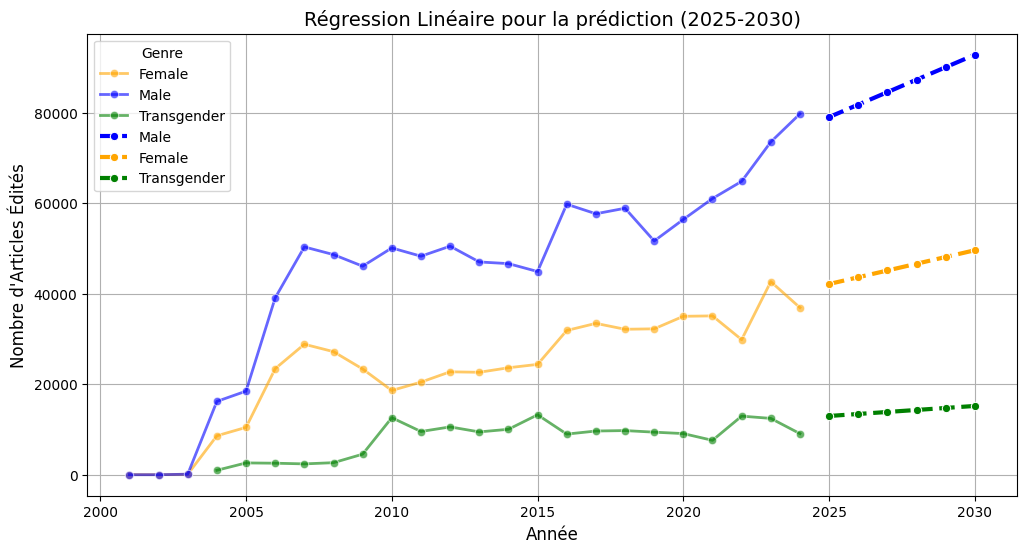

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# 1. Charger les fichiers d'origine sans modification
male_df = pd.read_csv('/content/drive/MyDrive/WIKI/MM.csv')
female_df = pd.read_csv('/content/drive/MyDrive/WIKI/Faa.csv')
transgender_df = pd.read_csv('/content/drive/MyDrive/WIKI/Twx.csv')

# 2. Concaténer les fichiers
df = pd.concat([male_df, female_df, transgender_df], ignore_index=True)

# 3. Nettoyage approfondi de la colonne "Gender"
df['Gender'] = df['Gender'].str.strip().str.capitalize()
valid_genders = ["Male", "Female", "Transgender"]
df = df[df['Gender'].isin(valid_genders)]

# 4. Extraire l'année depuis la colonne Timestamp
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")
df["Year"] = df["Timestamp"].dt.year

# 5. Agréger les données par année et par genre
df_grouped = df.groupby(['Year', 'Gender']).size().reset_index(name="Counts")

# 6. Régression Linéaire pour la prédiction 2025-2030
predictions = []
for gender in valid_genders:
    df_gender = df_grouped[df_grouped['Gender'] == gender]

    if len(df_gender) > 1:
        model = LinearRegression()
        model.fit(df_gender['Year'].values.reshape(-1, 1), df_gender['Counts'].values.reshape(-1, 1))

        future_years = np.array(range(2025, 2031)).reshape(-1, 1)
        future_counts = model.predict(future_years).flatten()
        future_counts = np.clip(future_counts, 0, None)

        for year, count in zip(future_years.flatten(), future_counts):
            predictions.append([year, gender, int(count)])

# 7. Créer un DataFrame pour les prédictions
pred_df = pd.DataFrame(predictions, columns=['Year', 'Gender', 'Counts'])

# 8. Visualisation améliorée
plt.figure(figsize=(12, 6))
color_map = {"Male": "blue", "Female": "orange", "Transgender": "green"}

# Tracé des courbes historiques
sns.lineplot(data=df_grouped, x='Year', y='Counts', hue='Gender', marker='o', linestyle='-', linewidth=2, alpha=0.6, palette=color_map)

# Tracé des prédictions (par-dessus les courbes historiques)
sns.lineplot(data=pred_df, x='Year', y='Counts', hue='Gender', marker='o', linestyle='dashed', linewidth=3, palette=color_map)

plt.title("Régression Linéaire pour la prédiction (2025-2030)", fontsize=14)
plt.xlabel("Année", fontsize=12)
plt.ylabel("Nombre d'Articles Édités", fontsize=12)
plt.legend(title="Genre")
plt.grid(True)

#9. Affichage du graphique
plt.show()
